# Introduction

## Basics
In agent-based models, the network structure is a crucial element and, thus, needs to be modeled with care.
When empirical network data are unavailable, simulation models must rely on network models.
Popy is a new way to quickly create network models ready to use in agent-based models.

Popy relies on a concept for creating network models that is mainly used in epidemiological models: the definition of so-called *contact layers*.
Contact layers act as links between agents by virtually providing a common space where agents assigned to the same contact layer meet.
In Popy, these contact layers are called *locations*.

To build a network model with Popy, one starts with a population of unconnected agents or with data to create the agents.
Then, one can use Popy to quickly define multiple locations, determining who will meet whom, when, and how.
Popy uses those location definitions to generate the desired network model by creating location instances (and, if needed agent instances), assigning the agents to the locations, and, thus, build a bipartite network of agents and locations.
In the last step, this bipartite network can, thanks to Popy's full integration into [AgentPy](https://agentpy.readthedocs.io/en/latest/#), either be directly used in a simulation model or can be exported as an agent-level network. The following figure provides an overview of these steps:

![](popy_overview.png)

It is important to understand, that Popy is not a *population synthesizer*.
The main purpose of Popy is to connect agents via contact layers to easily generate a valid interaction structure for agent-based models.
Popy does not create any original data on the agent-level.
All the data Popy uses to create agents must be given by the user.
However, Popy makes it very easy to transform (empirical or artificial) micro-level data into agent populations of any size by providing convenient sampling tools.
In addition, Popy includes tools to inspect the network properties and compare it to empirical data.

### Locations

The heart of Popy is the location class `popy.Location`.
It serves as some kind of user interface when creating the network.
The class `popy.Location` provides several methods which can be used to determine, for instance, which agents and how many are assigned to an instance of that location, if a location should be nested into another location or how the edge weight between agents should be determined.

The code below provides an overview of the methods of `popy.Location`.
Those methods have to be overwritten by the user in order to specify a location property.
Each method and the corresponding return value will be processed a specific way by the Popy framework.
Some methods take an agent as input in order to define the locations with respect to the individual agent-attributes.
During the generation process (which runs behind the scenes), those methods which take the agent as input are executed for each agent.

In [1]:
import popy
import popy.utils as utils

class MyLocation(popy.Location):
    def setup(self) -> None:
        """Sets the value of certain location attributes."""
        self.size: int | None = None
        self.allow_overcrowding: bool = True
        self.static_weight: bool = False
        self.multi_melt: bool = True

    def filter(self, agent: popy.Agent) -> bool:
        """Assigns only agents with certain attributes to this location."""
        return True

    def split(self, agent: popy.Agent) -> str | float | str | list | None:
        """Creates seperated location instances for each value of an agent-attribute."""
        return None

    def stick_together(self, agent: popy.Agent) -> str | float:
        """Ensures that agents with a shared value on an attribute are assigned to the same
        location instance."""
        return agent.id

    def weight(self, agent: popy.Agent) -> float:
        """Defines the edge weight between the agent and the location instance."""
        return 1

    def project_weights(self, agent1: popy.Agent, agent2: popy.Agent) -> float:
        """Calculates the edge weight between two agents that are assigned to the same location 
        instance."""
        return min([self.get_weight(agent1), self.get_weight(agent2)])

    def find(self, agent: popy.Agent) -> bool:
        """Assigns the agent to a specific location instance that meets the requirements."""
        return True

    def nest(self) -> popy.Location | None:
        """Ensures that the agents assigned to the same instance of this location class
        are also assigned to the same instance of the returned location class."""
        return None

    def melt(self) -> list[popy.Location] | tuple[popy.Location]:
        """Merges the agents assigned to the instances of the returned location classes
        into one instance of this location class."""
        return []

## Generating static networks

Let's start with creating static networks using Popy.
In the second part, we create dynamic networks that are directly used in a simulation.

### Generating Agents

Although the main task of Popy is connecting agents via the definition of locations, Popy can also generate agents for you based on micro-level data.
This makes it easy to create *empirical-based* agents from, for instance, survey data.
For the following example, we assume that we want to create a network model for schools and have access to a sample of individual data collected in a school.

This is our example data:

In [2]:
import pandas as pd

df_school = pd.read_csv("example_school_data.csv", sep=";")
df_school.head()

,status,gender,grade,hours,friend_group
0,pupil,m,1.0,4,1
1,pupil,w,1.0,4,1
2,pupil,m,1.0,4,2
3,pupil,w,1.0,4,2
4,pupil,m,2.0,4,3


In [3]:
df_school.tail()

,status,gender,grade,hours,friend_group
37,teacher,w,NaN,9,0
38,teacher,m,NaN,10,0
39,teacher,w,NaN,5,0
40,social_worker,w,NaN,6,0
41,social_worker,w,NaN,4,0


The process of generating agents (and locations) is handled by the `PopMaker`.
Hence, the first step is to create an instance of `PopMaker`.

In [4]:
from popy.pop_maker import PopMaker

pop_maker = PopMaker()

To create agents from this dataset, we can simply use the method `create_agents()`.
This method creates one agent object for each row in the given dataset.
Each column is translated into an agent attribute with the corresponding value.

In [5]:
agents = pop_maker.create_agents(df=df_school)
agents

AgentList (42 objects)

The method `create_agents()` generates an [AgentPy-AgentList](https://agentpy.readthedocs.io/en/latest/reference_sequences.html#containers) containing the instances of `popy.Agent`.
Let's have look at the first agent:

In [6]:
type(agents[0])

popy.agent.Agent

In [7]:
vars(agents[0])

{'_var_ignore': [],
 'id': 1,
 'type': 'Agent',
 'log': {},
 'model': Model,
 'p': {},
 'cls': 'agent',
 'status': 'pupil',
 'gender': 'm',
 'grade': 1.0,
 'hours': 4,
 'friend_group': 1}

If we do not insert an agent class via the parameter `agent_class`, the default agent class of Popy is used to create the agent instances, but we could also use our own agent class (that inherits from `popy.Agent`):

In [8]:
class MyAgent(popy.Agent):
    pass

pop_maker = PopMaker()
agents = pop_maker.create_agents(
    df=df_school, 
    agent_class=MyAgent,
)
agents

AgentList (42 objects)

In [9]:
type(agents[0])

__main__.MyAgent

For now, this is enough information on how to create agents based on micro-level data using Popy.
More useful options for the generation of agents based on micro-level data can be found in chapter *From survey participants to agents*.

### Generating locations

Now let's turn to the generation of networks.
To generate a network with Popy, one has to define at least one location class.
Those location classes are used to generate location instances which are then connected to the agent instances in order to build a bipartite network.
We start by just using the default location class without defining any further attributes or methods.
Every location class defined by the user must inherit - directly or indirectly - from `popy.Location`.
We call our first location `ClassRoom`.

In [10]:
# Define a Location class
class ClassRoom(popy.Location):
    pass

Now we use the `PopMaker`-method `create_locations()` to create the location instances and - and this is important - to assign the agents to the location instances.
Thus, `create_locations()` needs both the agent population and the location classes (as a list):

In [11]:
locations = pop_maker.create_locations(agents=agents, location_classes=[ClassRoom])
locations

LocationList (1 object)

For now, we can ignore the location instances as well as the agent instances, as this part of the introduction focuses on the generation of static networks.
The important thing is that `create_locations()` has not only created the location instances with respect to the given agent population, but has also assigned the agents to the location according to the rules specified by the location classes.
We can check this by looking at the bipartite network:

In [12]:
pop_maker.plot_bipartite_network()

The node in the center of the graph is the location.
All other nodes are agents.
This means that if we use the default location class without further customization, only one location instance is created to which all agents are connected.
Since each agent is assigned to this one location instance, the result is a fully connected agent graph:

In [13]:
pop_maker.plot_agent_network()

### Generate agents and locations in one step

Before diving into all the details of the definition of location classes, let's simplify the process of generating agents and locations.
The method `make()` combines `create_agents()` and `create_locations()` into one simple method.
However, note that `make()` always creates the agents based on a given dataset.
If you already have a population of agents, use `create_locations()` instead. 

In [14]:
# create a PopMaker-Object
pop_maker = PopMaker()

# Let the PopMaker create agents and locations
agents, locations = pop_maker.make(
    df=df_school,
    location_classes=[ClassRoom],
)

In [15]:
pop_maker.plot_bipartite_network()

In [16]:
pop_maker.plot_agent_network()

### Setting the location size

In the next step, we specify the number of people in one classroom.
In this example, we assume tiny classrooms of four agents.
To set the number of agents per location, we need to overwrite the `setup()`-method.
Within the `setup()`-method we can set the number of agents by setting `self.size` to the desired value.

In [17]:
class ClassRoom(popy.Location):
    # Overwrite the method setup() to set the number of agents
    def setup(self):
        self.size = 4

In [18]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])

In [19]:
pop_maker.plot_bipartite_network()

In [20]:
pop_maker.plot_agent_network()

The network diagram above now shows multiple clusters of size around 4.
Each cluster represents one classroom.
If we set a specific size for a location, the PopMaker creates as many location instances with that size as needed.
The agents are then assigned randomly to one of these location instances.
As you can see, some classrooms have more than four members because the number of agents assigned to classrooms cannot be divided exactly by the desired number of four.
If you want to make sure that no classroom has more than four members, set the location attribute `allow_overcrowding` to `False`:

In [21]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
        self.allow_overcrowding = False

In [22]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])

In [23]:
pop_maker.plot_agent_network(node_attrs=df_school.columns)

### Specifying location visitors

The classrooms above are made of all agents.
But in many cases we want specific locations to be exclusively accessible to certain agents.
For this scenario the method `filter()` exists.
If this method returns `True`, an agent gets assigned to an instance of this location class.
The most common way to use this method is to specify a condition that requires a certain agent attribute to contain a certain value.

In this example we want classrooms to be only accessible for pupils.

In [24]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
    
    def filter(self, agent):
        return agent.status == "pupil"

In [25]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])

In [26]:
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

Now classrooms consist only of pupils, while all other agents do not belong to any location.

By the way: Besides looking at the network graph, the function `utils.location_information()` and `utils.location_crosstab()` provide usefull overviews of the created location instances and the assigned agents:

In [27]:
utils.location_information(
    locations=locations, 
    select_locations=ClassRoom,
    agent_attributes=["grade", "status"],
    output_format="df",
)

,location_id,grade,status,location_type
0,0,4.0,pupil,ClassRoom
1,0,1.0,pupil,ClassRoom
2,0,3.0,pupil,ClassRoom
3,0,3.0,pupil,ClassRoom
4,1,1.0,pupil,ClassRoom
5,1,1.0,pupil,ClassRoom
6,1,4.0,pupil,ClassRoom
7,1,2.0,pupil,ClassRoom
8,2,2.0,pupil,ClassRoom
9,2,4.0,pupil,ClassRoom


In [28]:
utils.location_crosstab(
    locations=locations, 
    select_locations=ClassRoom, 
    agent_attributes=["status"],
    output_format="df",
)

[index  location_id status  count location_type
 0                0  pupil      4     ClassRoom
 1                1  pupil      4     ClassRoom
 2                2  pupil      4     ClassRoom
 3                3  pupil      4     ClassRoom
 4                4  pupil      4     ClassRoom
 5                5  pupil      4     ClassRoom
 6                6  pupil      4     ClassRoom
 7                7  pupil      4     ClassRoom]

### Building separated locations

The above table shows that the classrooms are not separated by grade.
To seperate agents by grade, we could define one location class for each grade and use `filter()` to assign only agents with a specific grade value to a specific location.

A more convenient way to do it is to use the method `split()`.
For each agent, the method `split()` returns one value.
For each unique value, seperated location instances are created.
In this case, the method `split()` returns the attribute `grade` for each agents.
Thus, the PopMaker builds seperate classroom instances for each unique value of the agent attribute `grade`.

In [29]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
    
    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade

In [30]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])

pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="grade")

### Keeping agents together

In the following plot the nodes are colored by their attribute `friend_group`.
It shows that the members of friend groups are distributed over different classrooms.

In [31]:
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="friend_group")

Although this is a very realistic situation, in this example, we want that all friend group members are always in the same class.
To implement that, we use the location method `stick_together()`:
For each agent, the method `stick_together()` returns a specific value.
Agents with the same return value are sticked together.

In [32]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
    
    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group

In [33]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])

pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="friend_group")

### Edge weights

Until now, all edges between nodes have a weight of `1`.
The location method `weight()` can be used to set different weights.
In the following, we set the weight of all edges generated by a classroom to `5`.
This number could, for instance, represent that agents are together in classrooms for five hours.

In [34]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
    
    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group
    
    def weight(self, agent):
        return 5

In [35]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])

In [36]:
pop_maker.plot_bipartite_network()

In [37]:
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="grade")

To implement individual weights between an agent and a location, we could also let `weight()` return an agent attribute. 
In this case we use the agent attribute `agent.hours`:

In [38]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
    
    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group
    
    def weight(self, agent):
        return agent.hours
    

pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])

In [39]:
pop_maker.plot_bipartite_network()

In [40]:
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="grade")

As the value returned by `location.weight()` refers to the weight between the agent and the location, all the weights between the agents and the locations must be somehow combined when determining the weight between agents (aka graph projection).
The location method `project_weights()` defines how those weights are combined.
By default, `project_weights()` returns the smallest weight of the two to be combined.
The code cell below shows how `project_weights()` combines the two weights by default.
In this example, we keep this way of combining the weights, but this method could be easily rewritten.

In [41]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
    
    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group
    
    def weight(self, agent):
        return agent.hours
    
    def project_weights(self, agent1, agent2) -> float:
        return min([self.get_weight(agent1), self.get_weight(agent2)])

Note that we use the method `location.get_weight()` to access the weight between the agent and the location.

In [42]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])

pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="grade")

### Bringing together different agents

So far, we are able to connect agents who share a certain attribut value.
But what if we want to explicitly connect agents who have different values on a certain attribute?
One solution could be to simply give those agents we want to be in the same location the same value on a certain attribute and then define a location class that brings together these agents.

Another possibility is to *melt* different locations into one location.
To do this, we have to define at least three location classes:  Two or more locations that are the components that get melted into one location and one location that melts those components together.

Assume we want to create classrooms that consist of one teacher and four pupils.
To create such a location, we first define a location (`TeachersInClassRoom`) that consists of only one teacher.
Then we define a location (`PupilsInClassRoom`) that consists of four pupils.
Finally, we define a location (`ClassRoom`) that uses the method `melt()` to melt the two previously defined locations into one location.
The method `melt()` must return a tuple or list of at least two location classes that shall be melted into one.

[Hier hinzufügen, was alles von der Unterklasse und was von der Oberklasse übernommen wird]

In [43]:
# a location for teachers
class TeachersInClassRoom(popy.Location):
    def setup(self):
        self.size = 1

    def filter(self, agent):
        return agent.status == "teacher"

# a location for pupils
class PupilsInClassRoom(popy.Location):
    def setup(self):
        self.size = 4

    def filter(self, agent):
        return agent.status == "pupil"

# a location for teachers and pupils
class ClassRoom(popy.Location):
    def melt(self):
        return TeachersInClassRoom, PupilsInClassRoom

In [44]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])

pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

Now we bring back all other settings we made so far:

In [45]:
class TeachersInClassRoom(popy.Location):
    def setup(self):
        self.size = 1

    def filter(self, agent):
        return agent.status == "teacher"

class PupilsInClassRoom(popy.Location):
    def setup(self):
        self.size = 4

    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group

class ClassRoom(popy.Location):
    def melt(self):
        return TeachersInClassRoom, PupilsInClassRoom
    
    def weight(self, agent):
        return agent.hours
    
    def project_weights(self, agent1, agent2) -> float:
        return min([self.get_weight(agent1), self.get_weight(agent2)])
    
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom])
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

### More than one location

The melting of locations combines different locations into one location, but does not create multiple different location classes.
If we want to generate multiple different location types, we have to simply feed more than one location class into the `PopMaker`.

In the following, we introduce a `School` as a second type of location.
Each school has about `20` members.
(In order to keep the code clean, we skip the melting of locations temporarely.)

In [46]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
    
    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group
    
    def weight(self, agent):
        return agent.hours
    
    def project_weights(self, agent1, agent2) -> float:
        return min([self.get_weight(agent1), self.get_weight(agent2)])


class School(popy.Location):
    def setup(self):
        self.size = 20

pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom, School])

In [47]:
pop_maker.plot_bipartite_network()

In [48]:
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

### Nesting locations
The plot above shows two big clusters.
Each of those clusters represents one school.
The plot above also shows something unrealistic: The schools are connected because members of one class are not always in the same school.
We can use the `School`-method `stick_together()` to fix this issue.
This works because whenever an agent is assigned to a location instance, the agent gets a new attribute named after the location class.
This new attribute is set to a location instance identifier value.

In [49]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
    
    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group
    
    def weight(self, agent):
        return agent.hours
    
    def project_weights(self, agent1, agent2) -> float:
        return min([self.get_weight(agent1), self.get_weight(agent2)])

class School(popy.Location):
    def setup(self):
        self.size = 22

    def stick_together(self, agent):
        return agent.ClassRoom


pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom, School])

In [50]:
pop_maker.plot_bipartite_network()

In [51]:
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

Note that it is very important that the agents get assigned to classrooms before getting assigned to schools.
This means that the order of the creation of the locations is important and, hence, the order of the location classes given to the `location_classes` argument.

If we build schools before classrooms, the above method does not work the way intended:

In [52]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[School, ClassRoom])

pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

As we saw, the method `stick_together()` can be used to nest locations into other locations.
However, this approach is limited because we can only specify one location class as the return value of `stick_together()`.

Another way to nest locations into other locations is to use the location method `nest()`.
The method `nest()` can return `None` or a location class.
If `nest()` returns a location class, the location is nested into the returned location class.
For instance, to nest classrooms within schools, we must define the method `nest()` for the location `ClassRoom` and let this method return `School`.
Again, the order of location creation plays a crucial role: The level-1 location must always be created after the level-2 location.

In [53]:
class ClassRoom(popy.Location):
    def setup(self):
        self.size = 4
    
    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group
    
    def weight(self, agent):
        return agent.hours
    
    def project_weights(self, agent1, agent2) -> float:
        return min([self.get_weight(agent1), self.get_weight(agent2)])
    
    def nest(self):
        return School

class School(popy.Location):
    def setup(self):
        self.size = 20


pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[School, ClassRoom])

pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

`nest()` allows us to nest as many locations in as many levels as we want. [Anwendungsbeispiel?]
However, `nest()` has one disadvantage: Because the agents are first grouped into the level-2 location and then into the level-1 location, specific compositions defined at level 1 are not considered when grouping the agents into the level-2 locations.

The following example demonstrates that:

In [54]:
class TeachersInClassRoom(popy.Location):
    def setup(self):
        self.size = 1

    def filter(self, agent):
        return agent.status == "teacher"

class PupilsInClassRoom(popy.Location):
    def setup(self):
        self.size = 4

    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
class ClassRoom(popy.Location):
    def melt(self):
        return [TeachersInClassRoom, PupilsInClassRoom]
    
    def weight(self, agent):
        return agent.hours * 10
    
    def project_weights(self, agent1, agent2) -> float:
        return min([self.get_weight(agent1), self.get_weight(agent2)])
    
    def nest(self):
        return School

class School(popy.Location):
    def setup(self):
        self.size = 20
    
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[School, ClassRoom])
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

In [55]:
utils.location_crosstab(
    locations=locations, 
    select_locations=[ClassRoom], 
    agent_attributes="status",
    output_format="df",
)

[index  location_id   status  count location_type
 0                0    pupil      4     ClassRoom
 1                0  teacher      1     ClassRoom
 2                1    pupil      3     ClassRoom
 3                1  teacher      1     ClassRoom
 4                2    pupil      2     ClassRoom
 5                2  teacher      1     ClassRoom
 6                3    pupil      5     ClassRoom
 7                3  teacher      1     ClassRoom
 8                4    pupil      3     ClassRoom
 9                4  teacher      1     ClassRoom
 10               5    pupil      2     ClassRoom
 11               5  teacher      1     ClassRoom
 12               6    pupil      5     ClassRoom
 13               6  teacher      1     ClassRoom
 14               7    pupil      3     ClassRoom
 15               7  teacher      1     ClassRoom
 16               8    pupil      5     ClassRoom
 17               8  teacher      1     ClassRoom
 18               9    pupil      2     ClassRoom


As you can see in the graph and the table above, the compositions defined by `ClassRoom` are not always met.
That is due to the fact that the agents are first assigned to the schools independently of the settings defined by `ClassRoom`.
When the classrooms are built, there are not always the *necessary* agents in each school needed to meet the composition defined in `ClassRoom`.
This might not always be a problem.
However, if we want to ensure that classrooms always have the defined composition of agents, they have to be created before the schools are created and, thus, we have to use the method `stick_together()` to nest classrooms into schools:

In [56]:
class TeachersInClassRoom(popy.Location):
    def setup(self):
        self.size = 1

    def filter(self, agent):
        return agent.status == "teacher"

class PupilsInClassRoom(popy.Location):
    def setup(self):
        self.size = 4

    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group

class ClassRoom(popy.Location):
    def melt(self):
        return [TeachersInClassRoom, PupilsInClassRoom]
    
    def weight(self, agent):
        return agent.hours * 10
    
    def project_weights(self, agent1, agent2) -> float:
        return min([self.get_weight(agent1), self.get_weight(agent2)])

class School(popy.Location):
    def setup(self):
        self.size = 20
    
    def stick_together(self, agent):
        return agent.ClassRoom
    
pop_maker = PopMaker()
agents, locations = pop_maker.make(df=df_school, location_classes=[ClassRoom, School])
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

It is also possible to combine both nesting techniques.
We could first nest the class `ClassRoom` into `School` using `stick_together()` in order to get the composition wanted for `ClassRoom` and then use `nest()` to nest further locations into `School`, as it is done in the next example:

In [57]:
class TeachersInClassRoom(popy.Location):
    def setup(self):
        self.size = 1

    def filter(self, agent):
        return agent.status == "teacher"

class PupilsInClassRoom(popy.Location):
    def setup(self):
        self.size = 4

    def filter(self, agent):
        return agent.status == "pupil"
    
    def split(self, agent):
        return agent.grade
    
    def stick_together(self, agent):
        return agent.friend_group

class ClassRoom(popy.Location):
    def melt(self):
        return [TeachersInClassRoom, PupilsInClassRoom]
    
    def weight(self, agent):
        return agent.hours * 10
    
    def project_weights(self, agent1, agent2) -> float:
        return min([self.get_weight(agent1), self.get_weight(agent2)])

class School(popy.Location):
    def setup(self):
        self.size = 20
    
    def stick_together(self, agent):
        return agent.ClassRoom

class SoccerTeam(popy.Location):
    def setup(self):
        self.size = 11
    
    def nest(self):
        return School
    
pop_maker = PopMaker()
agents, locations = pop_maker.make(
    df=df_school, 
    location_classes=[
        ClassRoom, # nested into School using `stick_together()`
        School, 
        SoccerTeam, # nested into School using `nest()`
        ],
    )
pop_maker.plot_agent_network(node_attrs=df_school.columns, node_color="status")

This way we can nest multiple locations into one level-2 location and at the same time ensure that the composition of agents defined in `ClassRoom` is met in each school.
The order of the locations plays a crucial role:
1. The classrooms with the desired compositions are created
2. The schools are created keeping together whole classrooms
3. Soccer teams are created within the schools

### Inspecting the network

When building network models, it is important to evaluate the created networks to ensure they are a valid representation of the target network.
For this purpose, Popy provides a couple of tools.

#### Network measures

For a quick quanitative inspection of the network(s) produced, one can use `utils.network_measures()`:

In [58]:
utils.network_measures(agent_list=agents)

[{'diameter': 3,
  'density': 1.0,
  'transitivity': 1.0,
  'avg_clustering': 0.07632339757583048,
  'avg_path_length': 1.6473684210526316},
 {'diameter': 3,
  'density': 1.0,
  'transitivity': 1.0,
  'avg_clustering': 0.06558220927936918,
  'avg_path_length': 1.6666666666666667}]

If the network is divided into independent clusters, this function returns the measures for each cluster.

#### Affiliation statistics

To get a quick overview of the number of affiliations per agents or location, use `utils.eval_affiliations()`.
The first table shows how many agents are assigned to an instance of a location.
The second table shows the number of locations an agent is assigned to.

In [59]:
utils.eval_affiliations(agents=agents, locations=locations)



______________________________________
Number of agents per location
______________________________________

               n_agents                                              
                  count  mean       std   min   25%   50%   75%   max
location_class                                                       
ClassRoom           8.0   5.0  0.000000   5.0   5.0   5.0   5.0   5.0
School              2.0  21.0  1.414214  20.0  20.5  21.0  21.5  22.0
SoccerTeam          4.0  10.5  1.000000   9.0  10.5  11.0  11.0  11.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    42.000000
mean      2.952381
std       0.215540
min       2.000000
25%       3.000000
50%       3.000000
75%       3.000000
max       3.000000
Name: n_affiliated_locations, dtype: float64


#### Contact matrix

`utils.create_contact_matrix()` shows the contact intensity between agents using a contact matrix.
With no further input than the list of agents, the matrix shows the contact intensities for each pair of agents.

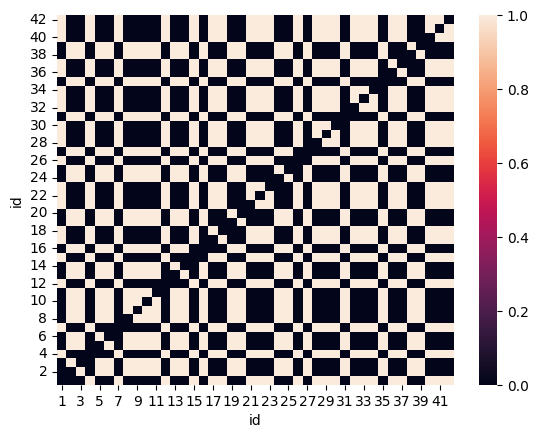

In [60]:
utils.create_contact_matrix(agents=agents)

To aggregate the results, simply insert the name of an agent attribute for `attr`.
For instance, the following matrix shows the number of contacts between the different gender groups.

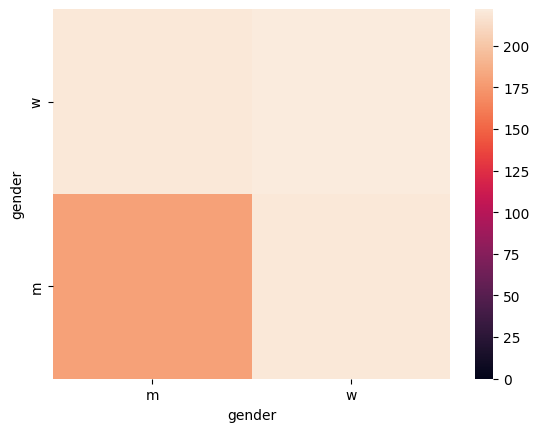

In [61]:
utils.create_contact_matrix(agents=agents, attr="gender")

By setting `return_df` to `True`, the data of the matrix can be returned, too.

,m,w
w,220,222
m,180,220


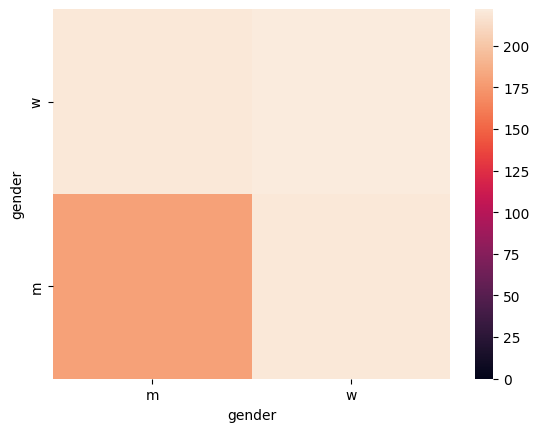

In [62]:
utils.create_contact_matrix(agents=agents, attr="gender", return_df=True)

### From survey participants to agents

As mentioned above, Popy is not a *population synthesizer*.
The main purpose of Popy is to connect existing agents.
However, Popy offers you to create agents based on a existing data before connecting them via locations.
Besides simply transforming a row of data into an agent, Popy has a few functionalities that allow you to build a population of agents from survey data relatively quickly.

To demonstrate these features of Popy, we use the following example data:

In [63]:
df = pd.DataFrame({
    "hh": [1,1,1,2,2,2,3,3],
    "gender": ["m", "w", "m", "w", "m", "w", "m", "w"],
    "school_age": [False, False, True, False, False, True, False, True],
    "sample_weight": [1,1,1,0.5,0.5,0.5,2,2],
})

df

,hh,gender,school_age,sample_weight
0,1,m,False,1.0
1,1,w,False,1.0
2,1,m,True,1.0
3,2,w,False,0.5
4,2,m,False,0.5
5,2,w,True,0.5
6,3,m,False,2.0
7,3,w,True,2.0


Let's start by defining two locations:

In [64]:
class Household(popy.Location):
    def split(self, agent):
        return agent.hh

class School(popy.Location):
    def filter(self, agent):
        return agent.school_age

In the second step, we build the population of agents using `PopMaker` and draw the resulting network:

In [65]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(
    df=df, 
    location_classes=[Household, School],
)

In [66]:
pop_maker.plot_bipartite_network()

In [67]:
pop_maker.plot_agent_network(node_attrs=df.columns)

Via the parameter `n_agents`, the method `make()` allows you to control the population size.
While the parameter `n_agents` is untouched, each row of the dataset is transformed into an agent.
When `n_agent` is set to any integer, `make()` samples the neccessary number of rows from the dataset.
When `n_agent` is larger than the number of rows in the dataset, the sampling happens *with replacement*, otherwise *without replacement*.

In [68]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(
    df=df, 
    location_classes=[Household, School],
    n_agents=30,
)

In [69]:
pop_maker.plot_bipartite_network()

In [70]:
pop_maker.plot_agent_network(node_attrs=df.columns)

If we only want to see who is in our population and not how the population is connected, we can also use the following command:

In [71]:
pop_maker.get_df_agents()

,cls,hh,gender,school_age,sample_weight,Household,School
0,agent,3,m,False,2.0,"gv=None-3, ...",None
1,agent,1,m,True,1.0,"gv=None-1, ...","gv=None-None, ..."
2,agent,2,w,True,0.5,"gv=None-2, ...","gv=None-None, ..."
3,agent,1,m,True,1.0,"gv=None-1, ...","gv=None-None, ..."
4,agent,1,m,True,1.0,"gv=None-1, ...","gv=None-None, ..."
5,agent,1,m,True,1.0,"gv=None-1, ...","gv=None-None, ..."
6,agent,2,w,False,0.5,"gv=None-2, ...",None
7,agent,1,w,False,1.0,"gv=None-1, ...",None
8,agent,2,w,False,0.5,"gv=None-2, ...",None
9,agent,1,m,False,1.0,"gv=None-1, ...",None


By default, the rows are sampled individually.
This might be what we want in many cases.
In this case, however, we want that people from the same household are always sampled together.
To define *sample units* that consist of more than one row, we can use the parameter `sample_level`:

In [72]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(
    df=df, 
    location_classes=[Household, School],
    n_agents=30,
    sample_level="hh",
)

In [73]:
pop_maker.plot_bipartite_network()

In [74]:
pop_maker.plot_agent_network(node_attrs=df.columns)

In [75]:
pop_maker.get_df_agents().sort_values("hh").reset_index(drop=True)

,cls,hh,gender,school_age,sample_weight,hh_original,Household,School
0,agent,1,m,False,2.0,3,"gv=None-1, ...",None
1,agent,1,w,True,2.0,3,"gv=None-1, ...","gv=None-None, ..."
2,agent,2,w,False,1.0,1,"gv=None-2, ...",None
3,agent,2,m,True,1.0,1,"gv=None-2, ...","gv=None-None, ..."
4,agent,2,m,False,1.0,1,"gv=None-2, ...",None
5,agent,3,m,False,2.0,3,"gv=None-3, ...",None
6,agent,3,w,True,2.0,3,"gv=None-3, ...","gv=None-None, ..."
7,agent,4,w,True,2.0,3,"gv=None-4, ...","gv=None-None, ..."
8,agent,4,m,False,2.0,3,"gv=None-4, ...",None
9,agent,5,w,True,2.0,3,"gv=None-5, ...","gv=None-None, ..."


We can see that only complete households were sampled from the data.
Another convenient thing happened in the background: the values of `"hh"` - our sampling unit - were replaced by unique values per sampled household.
(The original values are now in `"hh_original"`.)
You can turn this behavior off by setting `replace_sample_level_column` to `False`.

There is also an option to use sampling weight to adjust the sampling probability.
When using sample weights together with a *sample level*, the weight from the first row of an unit is used.

In [76]:
pop_maker = PopMaker()
agents, locations = pop_maker.make(
    df=df, 
    location_classes=[Household, School],
    n_agents=30,
    sample_level="hh",
    sample_weight="sample_weight",
)

pop_maker.plot_agent_network(node_attrs=df.columns)

By the way: Sometimes it might be neccessary to not directly build agents from the sampled data, but to adjust the data further.
In this case one can use `PopMaker.draw_sample()`.
This is the method which manages the whole process of sampling within `PopMaker.make()`.

In [77]:
df_sample = pop_maker.draw_sample(
    df=df,
    n=30,
    sample_level="hh",
    sample_weight="sample_weight",
)

df_sample

,hh,gender,school_age,sample_weight,hh_original
0,1,m,False,2.0,3
1,1,w,True,2.0,3
2,2,m,False,2.0,3
3,2,w,True,2.0,3
4,3,m,False,2.0,3
5,3,w,True,2.0,3
6,4,m,False,2.0,3
7,4,w,True,2.0,3
8,5,w,False,1.0,1
9,5,m,False,1.0,1


Now we could adjust the data as we want and then use it as input data in `PopMaker.make()` or `PopMaker.create_agents()`.

## Running simulations using Popy

In the previous part of this introduction, we have learned how to use Popy to build, evaluate and export static networks.
In the following part of this introduction, we will learn how to use Popy to directly run a simulation based on the defined network.
To perform simulations, Popy relies on [AgentPy](https://agentpy.readthedocs.io/en/latest/#) - a general ABM framework.
We recommend you to familiarize yourself with AgentPy first, as only some aspects of AgentPy are covered in this introduction.

In the following, we programme a simple infection simulation as an example of how to use Popy to run simulations.

### DataFaker

In the previous example, we used example data to create the population of agents.
In this example, we also use *fake* data, but this time we use a data generator provided by Popy to generate the data.
The DataFaker creates a data set of any size, which is similar to a classic survey data set.
`popy.data_fakers.soep_faker` creates data similiar to the [German Socio-Economic Panel](https://www.diw.de/en/diw_01.c.678568.en/research_data_center_soep.html).

We start by creating a dataset of 1000 rows:

In [78]:
from popy.data_fakers.soep import soep_faker

df_soep = soep_faker.soep(size=1000)
df_soep.head()

,age,gender,work_hours_day,nace2_division,hid,pid
0,45.0,female,9.393003,85,3286,8999
1,66.0,male,0.000000,-2,3286,7976
2,98.0,male,5.688487,99,7624,7671
3,43.0,male,3.072222,55,7624,6934
4,60.0,male,0.000000,-2,7624,7619


### A first Model

The object class `Model` is a key component of implementing simulation models using Popy (or AgentPy).
The class `Model` integrates all elements of the simulation and determines the simulation sequences.
Every simulation model which relies on Popy must have exactly one instance of `Model`.
(In fact, even the generation of static networks needs an instance of `Model`, which is created for you under the hood, to keep the code as simple as possible.)

`Model` has four core methods that structure the processes of the simulation model:

1. `Model.setup()`
2. `Model.step()`
3. `Model.update()`
4. `Model.end()`

Please refer to the [AgentPy documentation](https://agentpy.readthedocs.io/en/latest/reference_model.html) for more detailed information on those methods.

In addition to an *empty* `Agent` class and an *empty* `Location` class, we define our first own `Model` class below.
First we define the method `setup()`, which is executed according to the AgentPy logic at the beginning of the simulation.
Within the `setup()` method, we do nothing more than create a `PopMaker` as usual and then create agents and locations.
This time, however, we save everything as attributes of the `InfectionModel`.
It is also important to pass the `InfectionModel` to the `PopMaker` in the form of `self` via the `model` parameter.
This ensures that all agents and locations created via this `PopMaker` are assigned to the `InfectionModel` and vice versa.
This allows agents to access their environment during the simulation, for example.

In [79]:
import random

import popy
from popy.pop_maker import PopMaker
import popy.utils as utils

class Agent(popy.Agent):
    pass


class Home(popy.Location):
    pass


class InfectionModel(popy.Model):
    def setup(self):
        self.pop_maker = PopMaker(model=self)
        self.agents = self.pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = self.pop_maker.create_locations(
            agents=self.agents, location_classes=[Home],
        )

Now, we execute the simulation model.
Again, please refer to the [AgentPy documentation](https://agentpy.readthedocs.io/en/latest/overview.html#running-a-simulation) if needed.

In [80]:
parameters = {
    "steps": 50,
}
model = InfectionModel(parameters=parameters)
results = model.run()

Completed: 50 steps
Run time: 0:00:01.249013
Simulation finished


The simulation has now run, but practically nothing has happened except that the agents and locations have been created.
The `model` object now has the `agents` attribute, for example:

In [81]:
model.agents

AgentList (1000 objects)

In [82]:
model.locations

LocationList (1 object)

Now we add some code to make the model a working infection simulation.
We add the attributes `infection_status` and `days_since_infection` as well as the methods `infect` and `update_infection_status` to the agent.

What is relevant here is how the agent accesses other agents with which it is in contact.
This is done using the `Agent.neighbors()` method.
On the other hand, it is relevant how the agent determines *how much* contact it has or has had with the other agents.
This is done using the method `Agent.contact_weight()`.
Both methods include all locations that an agent visits.

In [83]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for agent_v in self.neighbors():
                if agent_v.infection_status == "susceptible":
                    infection_probability = 0.01 * self.contact_weight(agent_v)

                    if random.random() < infection_probability:
                        agent_v.infection_status = "exposed"


    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 2 <= self.days_since_infection <= 5:
                self.infection_status = "infectious"

            elif 6 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

Next, we define 4 locations.
A home `Home`, to which all agents of a household are assigned, a workplace `Work`, which groups the agents according to their occupational sectors, and a school `School`, which contains age-specific classes.
To ensure that each agent has contact with at least two other agents, we also define the location `Ring`, which connects the entire population along a ring using the predefined Popy class `RingLocation`.

In [84]:
class Home(popy.Location):
    def split(self, agent):
        return agent.hid

    def weight(self, agent):
        return 12

class Work(popy.Location):
    def setup(self):
        self.size = 10

    def filter(self, agent):
        return True if agent.work_hours_day > 0 and agent.nace2_division > 0 else False

    def split(self, agent):
        return agent.nace2_division

    def weight(self, agent):
        return agent.work_hours_day

class School(popy.Location):
    def setup(self):
        self.size = 25

    def filter(self, agent):
        return True if 6 <= agent.age <= 18 else False
    
    def split(self, agent):
        return agent.age

    def weight(self, agent):
        return 6

class Ring(popy.RingLocation):
    pass

We extend the `InfectionModel` so that 10 random agents are infected at the start of the simulation (`setup()`).
In `step()` we define what should happen in each individual time step of the simulation.
First, the method `update_infection_status()` is to be executed for each agent and then the method `infect()` for each agent.
If you are wondering about the strange syntax, have a look [here](https://agentpy.readthedocs.io/en/latest/overview.html#agent-sequences).
The method `update()` is also executed in each time step, but always after the method `step()`.
In `update()` we collect the number of agents ever infected per time step in order to visualize it after the simulation.

In [85]:
class InfectionModel(popy.Model):
    def setup(self):
        self.pop_maker = PopMaker(model=self)
        self.agents = self.pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = self.pop_maker.create_locations(
            agents=self.agents, 
            location_classes=[
                Home, 
                Work, 
                School, 
                Ring,
                ])

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"
    
    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()

    def update(self):
        self.record(
            "cumulative_infections",
            sum([1 for agent in self.agents if agent.infection_status != "susceptible"]),
        )

Let's execute the model:

In [86]:
parameters = {
    "steps": 50,
}
model = InfectionModel(parameters=parameters)
results = model.run()

Completed: 50 steps
Run time: 0:00:20.269344
Simulation finished


Below, you can see the number of infections per time step.

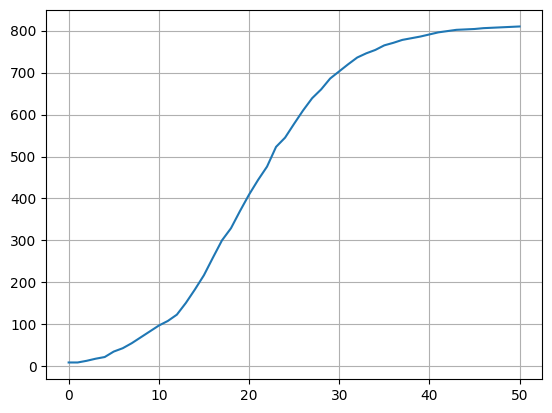

In [87]:
import matplotlib.pyplot as plt

plt.plot(results.variables.InfectionModel.cumulative_infections)
plt.grid()

Just because we can, let's have look at the network:

In [88]:
model.pop_maker.plot_bipartite_network()

In [89]:
model.pop_maker.plot_agent_network()

### Dynamic networks

Up to now, we have had purely static networks that have not changed once they have been created.
In Popy, there are two ways to change the networks during the simulation.
Firstly, agents can leave and join locations using the methods `Location.remove_agent()` and `Location.add_agent()`.
If a complete *move* of the agent from one location to another is not necessary, the connection weights between the agent and the location can also simply be varied.
If possible, this method is always preferable.
In the following, we will have a look at this method to create dynamic networks.

We now want to add another property to the infection simulation: Agents only visit the school or workplace if they are not currently symptomatically ill.

In order to exclude agents who are symptomatically ill from schools and workplaces, we adapt the `weight()` method in each case.
By default, the `weight()` method is executed repeatedly in each time step for each location so that the weights are always up to date
(as this can affect the performance of the simulation, you can set the attribute `Location.static_weight = True` in the `setup()` method to deactivate this function).

In [90]:
class Home(popy.Location):
    def split(self, agent):
        return agent.hid

    def weight(self, agent):
        if agent.infection_status == "symptomatic":
            return 3
        else:
            return 12

    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))

class Work(popy.Location):
    def setup(self):
        self.size = 10

    def filter(self, agent):
        return True if agent.work_hours_day > 0 and agent.nace2_division > 0 else False

    def split(self, agent):
        return agent.nace2_division

    def weight(self, agent):
        if agent.infection_status == "symptomatic":
            return 0
        else:
            return agent.work_hours_day
    
    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))

class School(popy.Location):
    def setup(self):
        self.size = 25

    def filter(self, agent):
        return True if 6 <= agent.age <= 18 else False
    
    def split(self, agent):
        return agent.age

    def weight(self, agent):
        if agent.infection_status == "symptomatic":
            return 0
        else:
            return 6
        
    def project_weights(self, agent1, agent2):
        return min(self.get_weight(agent1), self.get_weight(agent2))

class Ring(popy.Location):
    def subsplit(self, agent):
        pos = self.model.agents.index(agent)
        right = (pos + 1) % len(self.model.agents)
        return [pos, right]

In [91]:
import datetime as dt

class InfectionModel(popy.Model):
    def setup(self):
        self.pop_maker = PopMaker(model=self)
        self.agents = self.pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = self.pop_maker.create_locations(
            agents=self.agents, 
            location_classes=[
                Home, 
                Work, 
                School, 
                Ring,
                ])
        self.date = dt.date(2022, 1, 1)

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"
    
    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()

    def update(self):
        self.record(
            "cumulative_infections",
            sum([1 for agent in self.agents if agent.infection_status != "susceptible"]),
        )

In [92]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)
        self.infection_status = "susceptible"
        self.days_since_infection = 0

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for agent_v in self.neighbors():
                if agent_v.infection_status == "susceptible":
                    contact_weight = self.contact_weight(agent_v)
                    infection_probability = 0.01 * contact_weight

                    if random.random() < infection_probability:
                        agent_v.infection_status = "exposed"


    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 1 <= self.days_since_infection <= 2:
                self.infection_status = "infectious"

            elif 3 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"

            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

In [93]:
parameters = {
    "steps": 50,
}
model = InfectionModel(parameters=parameters)
results = model.run()

Completed: 50 steps
Run time: 0:00:24.752992
Simulation finished


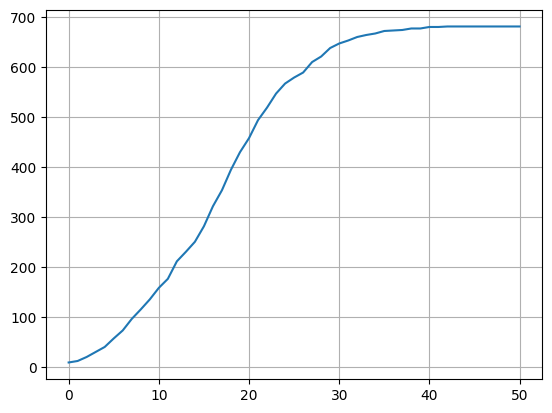

In [94]:
import matplotlib.pyplot as plt

plt.plot(results.variables.InfectionModel.cumulative_infections)
plt.grid()